<a id='Top'></a>

# Data Storytelling


                                                   By: Jun Ho Lee
                                                   
___


**Things to do: 10/6**

- Find the piece of paper that I took notes on regarding Ben's mentor call (or listen to the recorded version)
- Divide it into two groups? (downsampled vs. non-downsampled) 
- Make bar plots for denied percentage for different variables (states etc.) 
- Investigate the Wage columns vs. Target as well 
- Theil's U implementation?? 

- Wage Histogram distribution for Certified vs. Denied 

**NOTE**: NOT GOING TO USE PLOTLY + ipywidgets because they are not rendered online!

References: 

[Datacamp H1B_Dataset Example](https://www.datacamp.com/community/tutorials/predicting-H-1B-visa-status-python)  
[H1B Wage Distribution - Kaggle](https://www.kaggle.com/javidimail/h-1b-wage-distribution)  
[H1B Project - Independent Website](https://webpages.uncc.edu/sshinde5/)

<a id='Table of Contents'></a>
## Table of Contents

1. <a href='#Import Dataset'>Importing the Cleaned Dataset</a>
2. <a href='#Interactivity Introduction'>Introducing Interactivity with Plotly</a>


<a href='#Top'>Back to Top</a>

<a id='Import Dataset'></a>
____
### 1. Importing the Cleaned Dataset

Using the cleaned parameters saved in JSON format, we will load in the cleaned dataset that was saved from the previous notebook. 



**A. Import Necessary Libraries:**


In [64]:
import math
import itertools
from collections import Counter
import numpy as np
import pandas as pd
import scipy.stats as ss
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# # set option to see all the columns
pd.set_option('display.max_columns', 50)

# # suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)


**B. Read in JSON file to extract parameters:**

In [2]:
# Import JSON file for column information extraction 

with open('../data/H-1B_Feature_Creation_Cleaned_Params.json', 'r') as fp:
    h1b_params = json.load(fp)

final_cols = h1b_params['final_cols']
column_types = h1b_params['col_types']
date_columns = h1b_params['date_cols']

**C. Read in csv file**

In [5]:
h1b_df = pd.read_csv("../data/H-1B_Feature_Creation_Clean.csv", usecols = final_cols, dtype=column_types, low_memory=False, parse_dates=date_columns, infer_datetime_format=True)

**D. Verify Memory Usage and column data types**

In [6]:
# # Memory Usage 
# h1b_df.info(memory_usage='deep')

# # Columns
# h1b_df.columns

# # Column dtypes
# h1b_df.dtypes

<a href='#Table of Contents'>Back to Table of Contents</a>

<a id='Introduction'></a>
____
### 1. Introduction

Our final objective for this project is to correctly predict the `CASE_STATUS` of the applicant, making this project a classification problem. Thus `CASE_STATUS` will be our target variable and all other columns will be our feature variables. Currently there are 22 total columns in the dataset, leaving 21 feature variables for this dataset. There are however columns with redundant information (ex: `EMPLOYER_POSTAL_CODE` and `EMPLOYER_STATE_MAPPED`) and columns derived from other columns (ex: `PW_YEARLY_CONVERTED` from `PREVAILING_WAGE`). Thus feature engineering is necessary. 

As a first step however, I will investigate the distribution of our target variable: `CASE_STATUS`.



**- Pie Chart of Different Case Statuses**

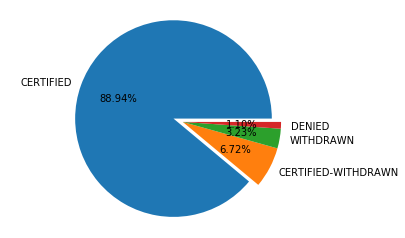

In [7]:
pie_chart_norm = h1b_df.CASE_STATUS.value_counts(normalize=True)
pie_chart_counts = h1b_df.CASE_STATUS.value_counts()

# # Pie Chart Plotting
fig, ax = plt.subplots()  # always use object oriented approach for plotting! 
                          # By default, plt.subplots(nrows=1, ncols=1)

explode = (0.1, 0, 0, 0)  # offset the first pie
ax.pie(pie_chart_norm, labels=pie_chart_norm.index, explode=explode, autopct='%1.2f%%')
ax.axis('equal') 
plt.show()

References:   
[Axes.pie - plt docs](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.pie.html)  
[Basic Pie Chart - plt demo](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py)  


Currently there are four different classes: 

1. CERTIFIED 
2. CERTIFIED-WITHDRAWN 
3. WITHDRAWN
4. DENIED 

and it looks like the data is heavily imbalanced, with Certified applicants taking up more than 85% of the whole dataset. However we are only interested in whether the applicant was certified or denied. So let's drop rows with `CERTIFIED-WITHDRAWN` or `WITHDRAWN`, making this classification a binary problem. This will make the dataset more imbalanced but we will be downsampling accordingly at the machine learning stage. 

**- Drop withdrawn / certified-withdrawn classes and make a new pie chart**

In [8]:
# # Make a copy of the original dataframe first (data_viz)
h1b_dviz = h1b_df.copy()

# # Change dtype (for CASE_STATUS only) to string because working with categoricals is hard
h1b_dviz['CASE_STATUS'] = h1b_dviz.CASE_STATUS.astype(str)

In [9]:
# # Drop the rows by index and reset index
wd_idx = h1b_dviz[h1b_dviz.CASE_STATUS == 'WITHDRAWN'].index
cert_wd_idx = h1b_dviz[h1b_dviz.CASE_STATUS == 'CERTIFIED-WITHDRAWN'].index
drop_idx = list(wd_idx) + list(cert_wd_idx)
h1b_dviz = h1b_dviz.drop(drop_idx)
h1b_dviz_clean = h1b_dviz.reset_index(drop=True)

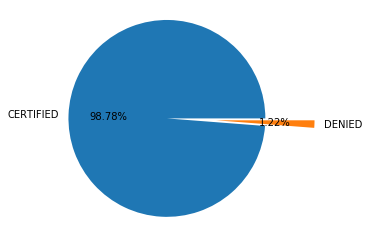

In [10]:
# # Making Pie Chart from the modified dataframe
ml_pie_chart_norm = h1b_dviz_clean.CASE_STATUS.value_counts(normalize=True)
ml_pie_chart_counts = h1b_dviz_clean.CASE_STATUS.value_counts()

# # Pie Chart Plotting
fig, ax = plt.subplots()  # always use object oriented approach for plotting! 
                          # By default, plt.subplots(nrows=1, ncols=1)

explode = (0, 0.5)  # offset the first pie
ax.pie(ml_pie_chart_norm, labels=ml_pie_chart_norm.index, explode=explode, autopct='%1.2f%%')
ax.axis('equal') 
plt.show()

Although the percentage of `CERTIFIED` class increased significantly, the `DENIED` class also rose a little bit - from 1.10% to 1.22%. The dataset however is still very imbalanced. 

<a id='Feature Creation'></a>
____
### 2. Feature Selection / Creation

For machine learning algorithms to perform well and be generalizable, a single feature shouldn't have too may factors. Using ***ipywidgets*** interactivity feature, we will quickly look through each categorical column to see how many *unique* values each column (feature) has and the *value_counts* of that column.

- Already did this step in Unit 5.5 (Feature Selection) 


<a href='#Table of Contents'>Back to Table of Contents</a>

### 3 Downsampling the data 

As can be seen above, the `CERTIFIED` cases take up more than 98% of the total cases. Analyzing this rawset will naturally skew every analysis towards the `CERTIFIED` category. Therefore, we will downsample the data accordingly so that the number of `CERTIFIED` is equal to the number of `DENIED` cases. Most importantly, we will randomly pick the data points from the `CERTIFIED` cases. For replicability issues, the random seed will stay identical. 


In [17]:
certified_df = h1b_dviz_clean[h1b_dviz_clean.CASE_STATUS == 'CERTIFIED']
denied_df = h1b_dviz_clean[h1b_dviz_clean.CASE_STATUS == 'DENIED']

In [18]:
print(certified_df.shape)
print(denied_df.shape)

(547402, 22)
(6787, 22)


In [19]:
sample_certified = certified_df.sample(n=6787, random_state=1)
sample_certified.shape

(6787, 22)

In [20]:
combined_total = pd.concat([sample_certified, denied_df])
combined_total.shape

(13574, 22)

Text(0.5, 1.0, 'Data Distribution after Downsampling')

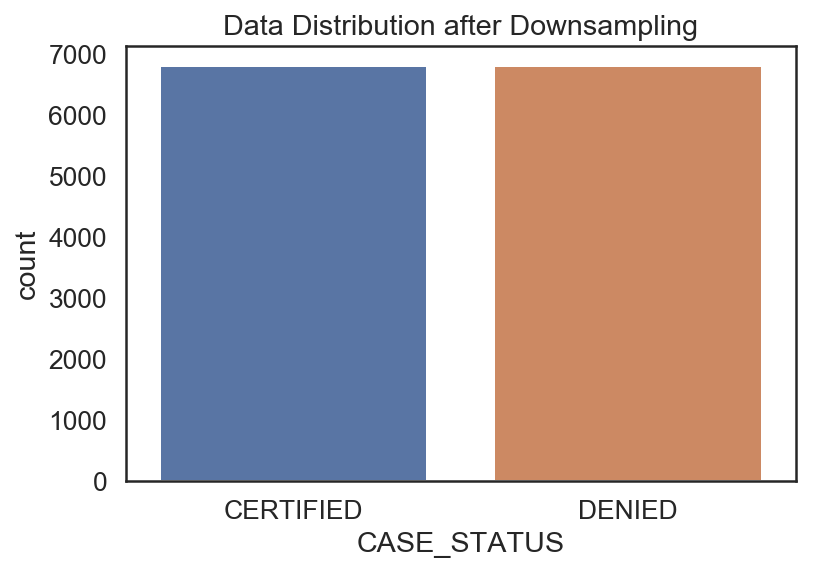

In [65]:
sns.countplot(x='CASE_STATUS', data=combined_total)
plt.title("Data Distribution after Downsampling")

<a id='Theils U'></a>
____
### 3. Cramers'V to find the correlation across categorical variables 

[Source: Kaggle Kernel (by shakedzy)](https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival)


References on Formatting the Heatmap:
[Better Heatmaps and Correlation Matrix Plots in Python](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec) $\rightarrow$ Now a pip package! [Link to pip Heatmapz](https://pypi.org/project/heatmapz/)

### Cramers V

- Defining Cramer's V

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#### Using the downsampled dataset

In [27]:
cols_final = ['CASE_STATUS',
 'VISA_CLASS',
 'EMPLOYER_STATE_MAPPED',
 'AGENT_REPRESENTING_EMPLOYER',
 'FULL_TIME_POSITION',
 'PW_UNIT_OF_PAY',
 'PW_WAGE_LEVEL',
 'WAGE_UNIT_OF_PAY',
 'H1B_DEPENDENT',
 'WILLFUL_VIOLATOR',
 'WORKSITE_STATE',
 'SOC_MAJOR_GROUP',
 'NAICS_BROAD']

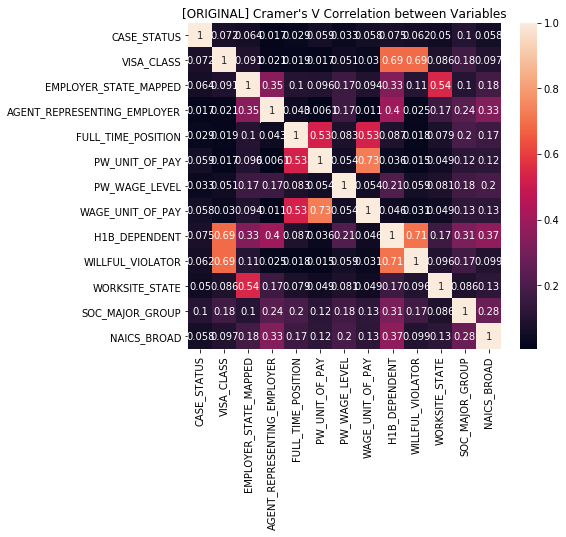

In [30]:
## Using the ORIGINAL Dataset

cols = cols_final

corrM = np.ones((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(h1b_dviz_clean[col1], h1b_dviz_clean[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("[ORIGINAL] Cramer's V Correlation between Variables");

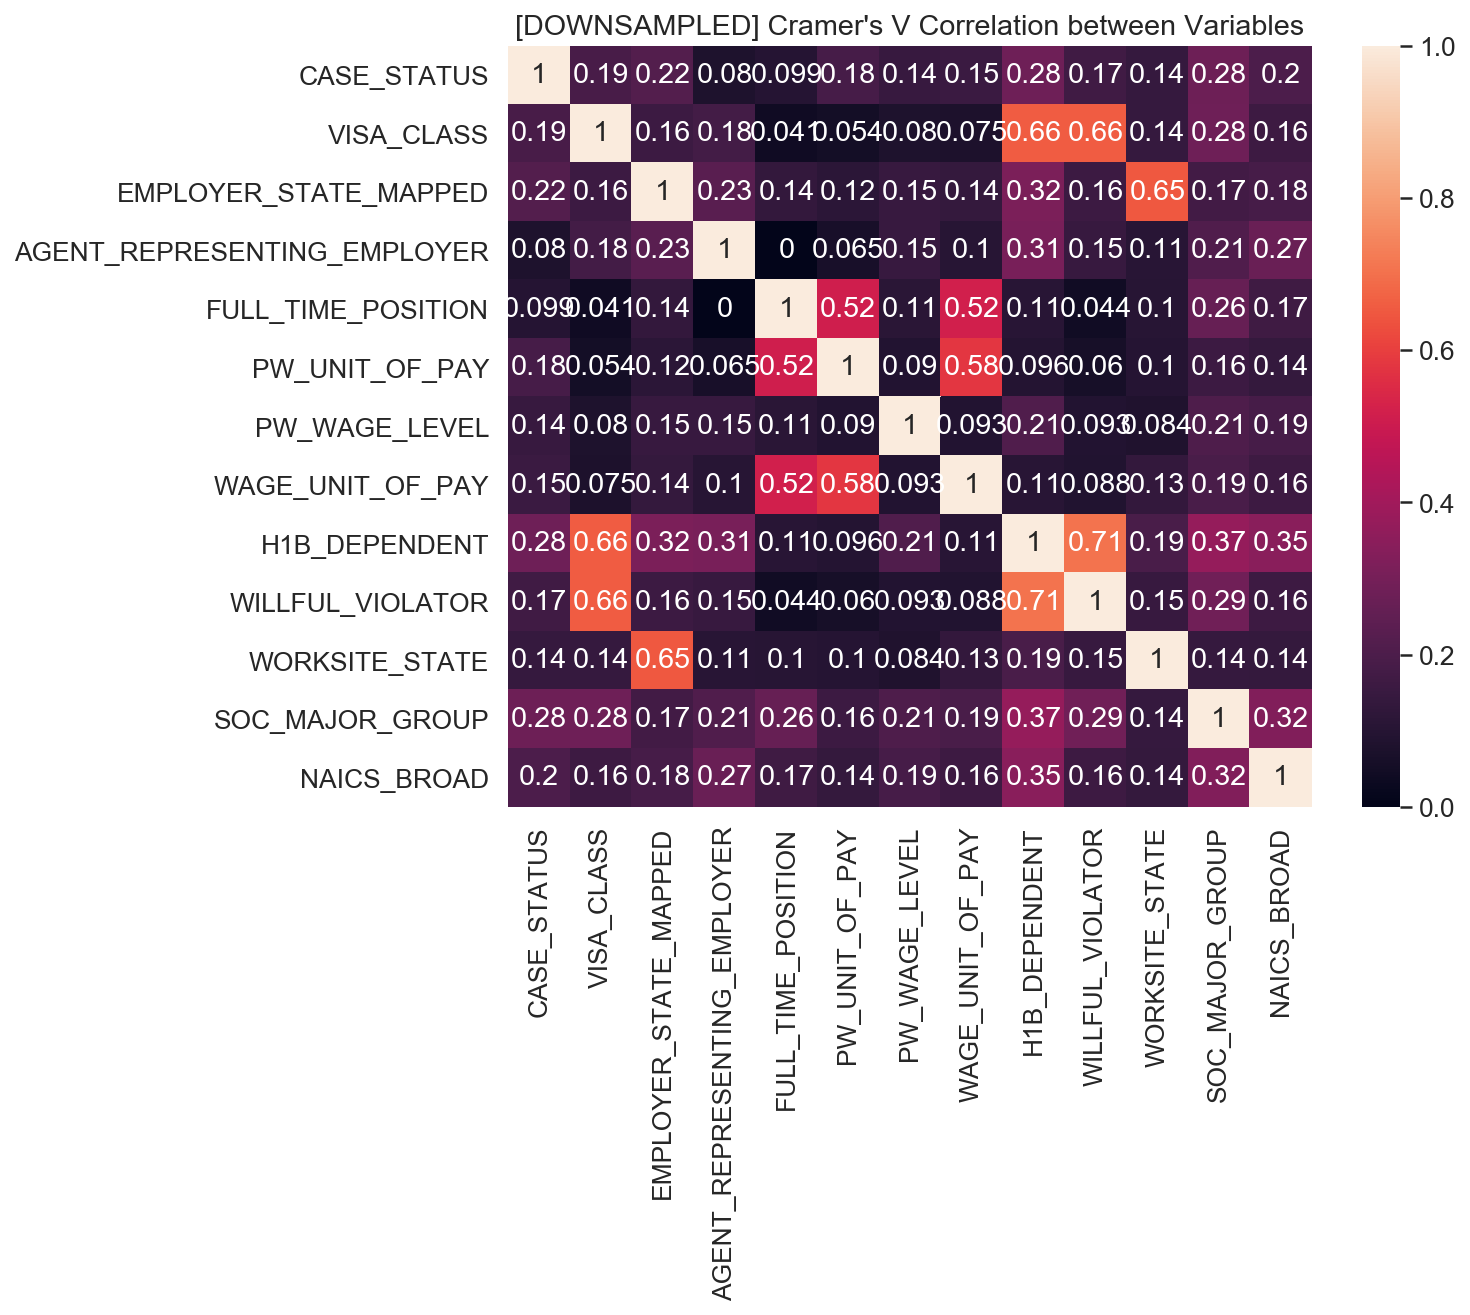

In [67]:
## Using the DOWNSAMPLED Dataset

cols = cols_final

corrM = np.ones((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(combined_total[col1], combined_total[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("[DOWNSAMPLED] Cramer's V Correlation between Variables");


#### Improving the Format of the Heatmap

In [68]:
from heatmap import heatmap, corrplot

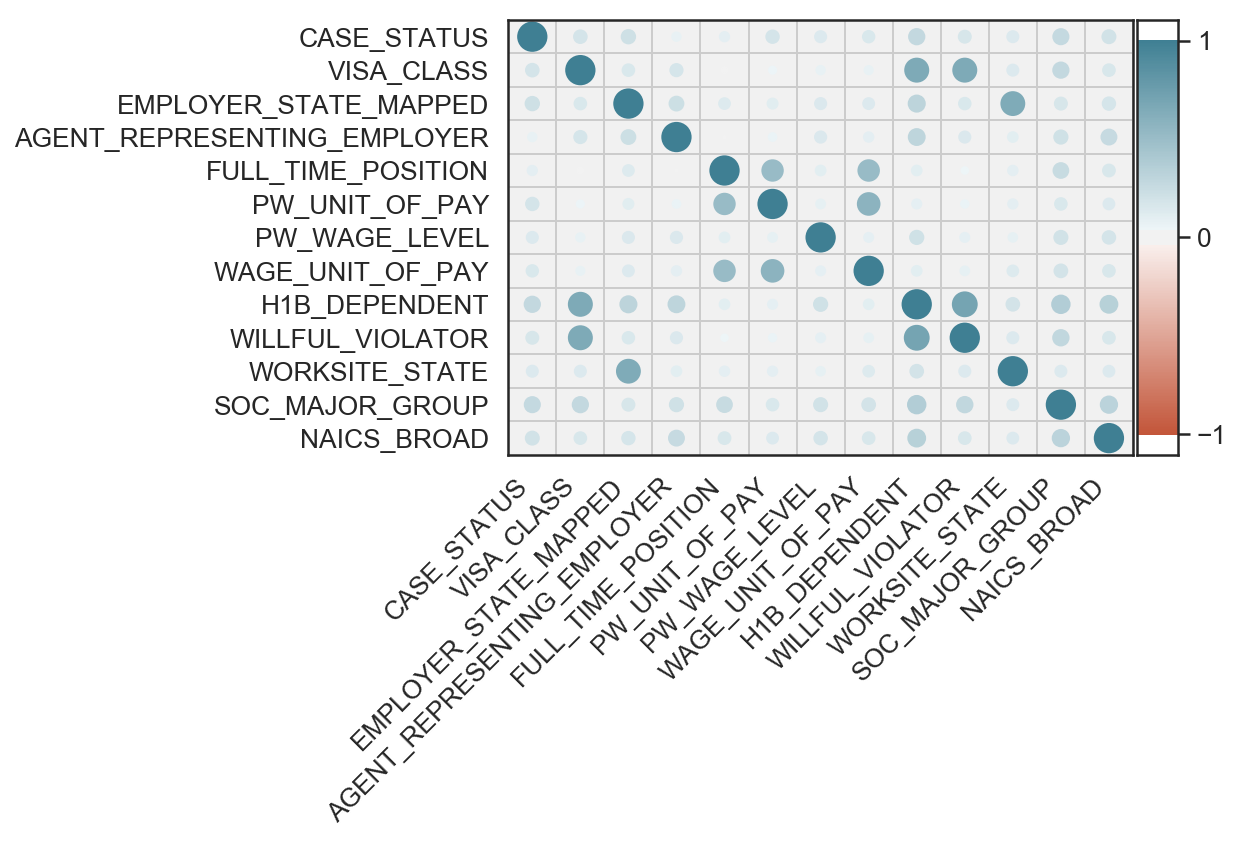

In [69]:
corrplot(corr, size_scale=800, marker='.')

Looks like `CASE_STATUS` target is correlated with `VISA_CLASS` / `EMPLOYER_STATE` / `H1B_DEPENDENT` / `SOC_MAJOR_GROUP` / `NAICS_BROAD` columns

In [85]:
len(combined_total.EMPLOYER_STATE_MAPPED.unique())

55

In [75]:
# combined_total.EMPLOYER_STATE_MAPPED.value_counts()

In [70]:
h1b_state_case = combined_total.groupby(['EMPLOYER_STATE_MAPPED','CASE_STATUS'])['CASE_SUBMITTED'].count()
h1b_state = combined_total.groupby(['EMPLOYER_STATE_MAPPED'])['CASE_SUBMITTED'].count()


In [71]:
pct = pd.DataFrame(h1b_state_case.div(h1b_state, level='EMPLOYER_STATE_MAPPED'))
pct


CASE_SUBMITTED
EMPLOYER_STATE_MAPPED CASE_STATUS                
AK                    DENIED              1.00000
AL                    CERTIFIED           0.38298
                      DENIED              0.61702
AR                    CERTIFIED           0.76190
                      DENIED              0.23810
...                                           ...
WI                    DENIED              0.53571
WV                    CERTIFIED           0.30769
                      DENIED              0.69231
WY                    CERTIFIED           0.57143
                      DENIED              0.42857

[108 rows x 1 columns]

In [79]:
grouped = pct.groupby(level='CASE_STATUS')  # New Groupby Object
certified = grouped.get_group('CERTIFIED')  # Get only the 'certified' ratio
certified.columns = ['RATIO']               # Rename the column to "Ratio"
certified.index = certified.index.droplevel(1)  # drop the certified column to retain only state info
certified.to_excel("certified_ratio_by_state.xlsx")


### Visualizing the H1B Approval Rates by State  - Top 5 vs Bottom 5 

#### See Graph Here: https://datawrapper.dwcdn.net/xViUZ/1/

### Statistical Calculations 

- one sample t-test (entire 55 states against ratio of 0.5) [Reference: One-Sample T-Test](https://stattrek.com/statistics/dictionary.aspx?definition=one-sample%20t-test) and [this](https://stattrek.com/hypothesis-test/mean.aspx)

    - Use the one-sample t-test to determine whether the hypothesized mean differs significantly from the observed sample mean.
- two sample (unequal variance) independent t-test (sample of top 5 states vs. the entire sample) 

[T-Test Reference](https://www.investopedia.com/terms/t/t-test.asp) 
  - refer to Image by *Julie Bang* on what T-Test to use

We are trying to see if the approval ratio is greater than 0.5 (approval by chance) To do that, we employ the one tailed one sample t-test.

* Note: We would ideally want to do a one tailed t-test, but scipy.stats only offers two-sided... Therefore we would need to divide the p-value by 2 and compare that to the significance level. [Documentation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_1samp.html)

#### Hypothesis Plan (One-sided) 

- Null Hypothesis: μ >= 0.5

- Alternative hypothesis: μ < 0.5

- Significance Level: 0.05 




In [122]:
from scipy import stats

alpha = 0.05

results = stats.ttest_1samp(certified['RATIO'], 0.5)

print("T-Statistic: {} and p-value: {}".format(results[0],results[1]))
print()

## Divide by two since it is one sided! 
if (results[1]/2) < alpha:
    print("Reject Null Hypothesis")
else: 
    print("Accept Null Hypothesis")

T-Statistic: -4.44573874515688 and p-value: 4.6255869000644627e-05

Reject Null Hypothesis


#### Helpful References: 

[Medium - Hypothesis Test](https://medium.com/@kangeugine/hypothesis-test-21795f788f7d)

We rejected the null hypothesis so the population mean is below 0.5 

### Additional Statistical Calculations: 

- Two-Sample (Independent) T-Test (Unequal Variance) 

Two-sided (equal or not equal to)

One Sample: Top 5 States with Approval Rates
Other Sample: Entire Sample of Approval Rates

[Two-Sample TTest Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [132]:
## Approval Rates for top 5 states
top_five_states = certified['RATIO'].sort_values(ascending=False)[:5]

In [139]:
## Comparing 'top_five' with the national mean to see if th means are statistically different


results_twosamp = stats.ttest_ind(certified['RATIO'], top_five_states, equal_var=False)

print("T-Statistic: {} and p-value: {}".format(results_twosamp[0],results_twosamp[1]))
print()

## Divide by two since it is one sided! 
if (results_twosamp[1]) < alpha:
    print("Reject Null Hypothesis")
else: 
    print("Accept Null Hypothesis")


T-Statistic: -6.826941122401689 and p-value: 0.00014393552849013431

Reject Null Hypothesis


We rejected the null hypothesis. 
Therfore there is a statistical difference in the approval rate in the top 5 states **(AR / MD / NJ / TX / MI)** compared to the national average.